Есть 457 TCP-traceroute по порту **80** до хостов во [Фримонте](https://ru.wikipedia.org/wiki/%D0%A4%D1%80%D0%B8%D0%BC%D0%BE%D0%BD%D1%82_(%D0%9A%D0%B0%D0%BB%D0%B8%D1%84%D0%BE%D1%80%D0%BD%D0%B8%D1%8F%29), отличающихся последним битом, из всех живых RIPE Atlas probe с кодом страны RU.
Расстояние то Москвы до Фримонта [~9500 км.](https://ru.wikipedia.org/wiki/%D0%9E%D1%80%D1%82%D0%BE%D0%B4%D1%80%D0%BE%D0%BC%D0%B8%D1%8F), что означет минимум 91.5ms RTT.

In [1]:
test_fname = 'RIPE-Atlas-measurement-8844226.json'

In [2]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [3]:
%matplotlib inline

In [4]:
def dataset(fname):
    ds = []
    with open(fname) as fd:
        for line in fd:
            line = json.loads(line)
            dst_addr = line['dst_addr']
            last_hop = line['result'][-1]['hop']
            hops, rtt, flags, ttl = set(), set(), set(), set()
            stable_route = True
            for hop in line['result']:
                for pkt in hop['result']:
                    if pkt.get('from') == dst_addr:
                        hops.add(hop['hop'])
                        rtt.add(pkt['rtt'])
                        flags.add(pkt['flags'])
                        ttl.add(pkt['ttl'])
                        if hop['hop'] != last_hop:
                            stable_route = False
            if stable_route and len(rtt) and last_hop != 1:
                prev_hop = {pkt.get('from') for pkt in line['result'][-2]['result']}
                prev_loss = bool(None in prev_hop)
                prev_hop.discard(None)
                prev_bad = []
                for addr in prev_hop:
                    if not addr.startswith('173.230.159.'):
                        prev_bad.append(addr)
            else:
                prev_hop, prev_loss, prev_bad = None, None, None
            ds.append({'prb_id': line['prb_id'],
                   'last_hop': last_hop,
                   'hops': hops,
                   'rtt': min(rtt) if len(rtt) else None,
                   'flags': tuple(sorted(flags)),
                   'maxttl': max(ttl) if len(ttl) else None, 
                   'ttl': ttl,
                   'stable_route': stable_route,
                   'prev_hop': prev_hop,
                   'prev_loss': prev_loss,
                   'prev_bad': tuple(prev_bad) if prev_bad is not None else None,
                  })
    return pd.DataFrame(data=ds, index=[_['prb_id'] for _ in ds])

In [5]:
test = dataset(test_fname)
print test.shape
test.head()

(458, 11)


,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
10096,"(SA,)",{12},12,56.0,10096,(),{173.230.159.11},False,188.942,True,{56}
10184,"(SA,)",{12},12,54.0,10184,(),{173.230.159.15},False,194.311,True,{54}
10215,"(RA,)",{6},6,58.0,10215,"(185.30.16.70,)",{185.30.16.70},False,1.291,True,{58}
10228,"(SA,)",{15},15,42.0,10228,(),{173.230.159.7},True,267.230,True,{42}
10234,"(SA,)",{12},12,52.0,10234,(),{173.230.159.13},False,177.346,True,{52}


Посмотрим на аномалии с TTL. Серер посылает пакеты с TTL=64, с каким значением они доходят до клиента?

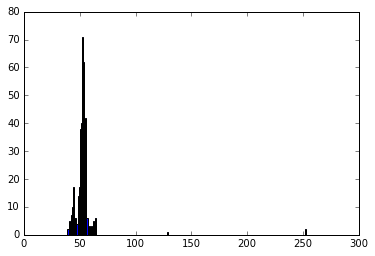

In [6]:
pyplot.hist(test.maxttl.dropna(), bins=range(256));

In [7]:
bad_ttl, test = test[test.maxttl > 58], test[~(test.maxttl > 58)]
bad_ttl.sort_values('last_hop')

,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
10869,"(SA,)",{1},1,64.0,10869,None,None,None,0.691,True,{64}
17694,"(SA,)",{1},1,64.0,17694,None,None,None,0.530,True,{64}
20933,"(SA,)",{1},1,64.0,20933,None,None,None,242.790,True,{64}
20980,"(SA,)",{1},1,128.0,20980,None,None,None,247.985,True,{128}
31581,"(SA,)",{1},1,64.0,31581,None,None,None,0.656,True,{64}
21851,"(SA,)",{1},1,64.0,21851,None,None,None,0.713,True,{64}
11361,"(SA,)",{3},3,62.0,11361,"(94.230.160.21,)",{94.230.160.21},False,0.455,True,{62}
20904,"(SA,)",{3},3,62.0,20904,"(89.222.165.105,)",{89.222.165.105},False,0.558,True,{62}
23082,"(SA,)",{3},3,62.0,23082,"(185.30.16.70,)",{185.30.16.70},False,1.158,True,{62}
2368,"(R,)",{3},3,63.0,2368,"(172.31.136.6,)",{172.31.136.6},False,1.625,True,{63}


Посмотрим на RTT. Аномально малый RTT означает, что либо пробник находится ближе к Фремонту, чем Россия, либо пакет "поддельный", от промежуточного proxy-сервера или блокиратора "по IP":

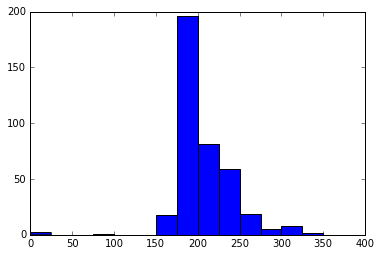

In [8]:
pyplot.hist(test.rtt.dropna(), bins=np.arange(0, 400, 25)) ;

In [9]:
bad_rtt, test = test[test.rtt < 150], test[~(test.rtt < 150)]
bad_rtt.sort_values('rtt')

,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
10215,"(RA,)",{6},6,58.0,10215,"(185.30.16.70,)",{185.30.16.70},False,1.291,True,{58}
3828,"(SA,)",{255},255,58.0,3828,(),{},True,3.279,True,{58}
12642,"(RA, SA)",{14},14,53.0,12642,(),{173.230.159.13},True,88.852,True,{53}


А также посмотрим, где пришло что-то отличное от SYN-ACK:

In [10]:
bad_synack, test = test[test.flags != ('SA',)], test[~(test.flags != ('SA',))]
bad_synack.sort_values('last_hop')

,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
30520,(),{},1,NaN,30520,None,None,None,NaN,True,{}
4358,"(RA,)",{11},11,53.0,4358,(),{173.230.159.7},False,241.479,True,{53}
26656,"(RA,)",{11},11,54.0,26656,(),{173.230.159.1},False,188.693,True,{54}
3879,"(RA,)",{13},13,55.0,3879,(),{173.230.159.1},False,185.769,True,{55}
11301,"(RA, SA)",{14},14,55.0,11301,(),{173.230.159.1},False,191.481,True,{55}
30266,"(RA, SA)",{15},15,55.0,30266,(),{173.230.159.13},False,186.391,True,{55}
19803,"(RA, SA)",{15},15,53.0,19803,(),{173.230.159.3},False,170.331,True,{53}
19106,"(RA,)",{15},15,51.0,19106,(),{173.230.159.3},False,205.398,True,{51}
13921,"(RA,)",{16},16,50.0,13921,(),{173.230.159.3},False,181.830,True,{50}
10872,(),{},255,NaN,10872,None,None,None,NaN,True,{}


И на хосты, где предпоследний хоп не в AS Linode:

In [11]:
bad_prevhop, test = test[(test.prev_bad != ()) & ~test.prev_bad.isnull()], test[~((test.prev_bad != ()) & ~test.prev_bad.isnull())]
bad_prevhop

,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
3959,"(SA,)",{3},3,40.0,3959,"(192.168.8.1,)",{192.168.8.1},True,386.048,True,"{40, 31}"


Посмотрим на аномально далёкие ответы, за пределами радиуса интернета в хопах:

In [12]:
bad_radius, test = test[test.last_hop > 64], test[~(test.last_hop > 64)]
bad_radius.sort_values('maxttl')

,flags,hops,last_hop,maxttl,prb_id,prev_bad,prev_hop,prev_loss,rtt,stable_route,ttl
21116,"(SA,)",{255},255,46.0,21116,(),{},True,272.353,True,{46}
19846,"(SA,)",{255},255,46.0,19846,(),{},True,196.226,True,{46}
15144,"(SA,)",{255},255,46.0,15144,(),{},True,267.406,True,{46}
3782,"(SA,)",{255},255,46.0,3782,(),{},True,221.616,True,"{44, 46}"
20473,"(SA,)",{255},255,48.0,20473,(),{},True,192.466,True,{48}
12794,"(SA,)",{255},255,49.0,12794,(),{},True,178.766,True,{49}
3696,"(SA,)",{255},255,49.0,3696,(),{},True,189.016,True,"{49, 47}"
27858,"(SA,)",{255},255,49.0,27858,(),{},True,197.887,True,"{40, 49}"
28690,"(SA,)",{255},255,49.0,28690,(),{},True,241.672,True,{49}
17763,"(SA,)",{255},255,50.0,17763,(),{},True,189.102,True,{50}


Возможно, эти провайдеры просто блокируют работу traceroute или RIPE Atlas внезапно триггерит лимиты на ICMP. Нельзя однозначно сказать, что происходит на сети этих провайдеров, трассы выглядят примерно так:
```
Probe #30083
  1 192.168.1.1               6.9 ms    1.2 ms          *    8.0 ms    9.4 ms
  2 10.254.254.13            19.2 ms   17.2 ms    11.8 ms   19.5 ms   19.4 ms
  3 *                              *         *          *         *         *
  4 *                              *         *          *         *         * 
  5 *                              *         *          *         *         * 
  6 *                              *         *          *         *         * 
  7 *                              *         *          *         *         * 
255 74.82.3.171    AS63949  199.6 ms  199.5 ms   209.7 ms  209.7 ms  197.4 ms
```

У взятых наудачу измерений prb_id=19846 трейс обрывается в AS39087 (ПАКТ), у prb_id=11325 в AS8359 (МТС),
у prb_id=1341 в AS39264 (Метромакс), у prb_id_30083 в AS197826 (Skynet) и у prb_id=17763 в AS21446 (ВПК Телеком).

In [13]:
print len(bad_radius) + len(bad_prevhop) + len(bad_rtt) + len(bad_synack) + len(bad_ttl) + len(test)
print len(bad_prevhop) + len(bad_rtt) + len(bad_synack) + len(bad_ttl), len(test)

458
77 357


Т.е. 77 проб из 434 (про которые что-то можно сказать определённое) наблюдают явные аномалии даже при обработке трафика на *http* порт, что по порядку величины совпадает с 7% провалом трафика на MSK-IX.

Интересно повторить эксперимент с traceroute на порт 443.